In [1]:
import logging
# Suppresses warning errors, there are too many of them there about caches from wbdata
logging.getLogger("shelved_cache.persistent_cache").setLevel(logging.ERROR)
import wbdata
import pandas as pd
import datetime
import os
import numpy as np

In [2]:
class HDIData:
    def __init__(self, filepath: str):
        """
        Initialize the HDIData object by loading a CSV file into a DataFrame.
        """
        # Read CSV safely
        self.df = pd.read_csv(filepath, encoding="ISO-8859-1")
        
        # Standardize column names
        self.df.columns = (
            self.df.columns
            .str.strip()
            .str.lower()
            .str.replace(' ', '_')
        )
    
    def _reshape_long(self, df, indicators: dict):
        """
        Converts wide-format year columns into long format for easier filtering.
        """
        id_vars = ['iso3', 'country', 'region']
        
        # Determine columns that match indicator prefixes
        value_vars = [
            col for col in df.columns 
            if any(col.startswith(prefix + "_") for prefix in indicators.keys())
        ]
        
        # Melt to long format
        long_df = df.melt(
            id_vars=id_vars,
            value_vars=value_vars,
            var_name='metric_year',
            value_name='value'
        )
        
        # Split 'metric_year' into 'metric' and 'year'
        long_df[['metric', 'year']] = long_df['metric_year'].str.rsplit('_', n=1, expand=True)
        long_df['year'] = long_df['year'].astype(int)
        long_df.drop(columns='metric_year', inplace=True)

        # Add readable metric names
        long_df['metric_name'] = long_df['metric'].map(indicators)
        
        return long_df

    def get_data(self, indicators: dict, countries=None, start_year=None, end_year=None):
        """
        Retrieve filtered data based on an indicator dictionary, countries, and year range.

        Args:
            indicators (dict): Dictionary of indicator IDs and readable names.
            countries (list or str): Country or list of countries to filter by.
            start_year (int): Start year for filtering.
            end_year (int): End year for filtering.
        """
        # Convert to long format using the indicators provided
        long_df = self._reshape_long(self.df, indicators)
        
        # Filter by countries
        if countries is not None:
            if isinstance(countries, str):
                countries = [countries]
            long_df = long_df[long_df['country'].str.lower().isin([c.lower() for c in countries])]
        
        # Filter by year range
        if start_year is not None:
            long_df = long_df[long_df['year'] >= start_year]
        if end_year is not None:
            long_df = long_df[long_df['year'] <= end_year]
        
        return long_df.reset_index(drop=True)


In [3]:
def load_indicators(indicators: dict, countries=None, years=None, folder_path='P5_Indicator'):
    """
    Load environmental/social indicators from CSV files and filter by country/year.

    Parameters
    ----------
    indicators : dict
        Dictionary mapping variable abbreviations to readable names, e.g.:
        {"BCA": "Biodiversity Conservation Area", "BER": "Biodiversity Expenditure Ratio"}.
    countries : str | list[str] | None
        Country or list of countries to filter.
    years : int | list[int] | tuple(int, int) | None
        Single year, list of years, or range (start, end) to filter.
    folder_path : str
        Path to the folder containing CSV files.

    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        ['country', 'iso', 'variable', 'variable_name', 'year', 'value']
    """
    all_dfs = []

    for var, var_name in indicators.items():
        filename = os.path.join(folder_path, f"{var}_ind_na.csv")
        if not os.path.exists(filename):
            raise FileNotFoundError(f"File {filename} not found.")
        
        # Load CSV safely
        df = pd.read_csv(filename)
        
        # Standardize columns
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        
        # Identify year columns for this variable (e.g., bca.ind.1990)
        year_cols = [col for col in df.columns if col.startswith(var.lower() + '.ind.')]
        
        # Melt wide -> long
        long_df = df.melt(
            id_vars=['iso', 'country'],
            value_vars=year_cols,
            var_name='metric_year',
            value_name='value'
        )
        
        # Extract year and add metadata
        long_df['year'] = long_df['metric_year'].str.split('.').str[-1].astype(int)
        long_df['variable'] = var
        long_df['variable_name'] = var_name
        long_df = long_df.drop(columns='metric_year')
        
        all_dfs.append(long_df)
    
    # Combine multiple indicators
    result = pd.concat(all_dfs, ignore_index=True)
    
    # Filter by countries
    if countries is not None:
        if isinstance(countries, str):
            countries = [countries]
        result = result[result['country'].str.lower().isin([c.lower() for c in countries])]
    
    # Filter by years
    if years is not None:
        if isinstance(years, tuple):  # range
            result = result[(result['year'] >= years[0]) & (result['year'] <= years[1])]
        elif isinstance(years, list):
            result = result[result['year'].isin(years)]
        else:  # single year
            result = result[result['year'] == years]
    
    return result.reset_index(drop=True)

In [4]:
def fetch_wbdata(indicators, countries="all", start_year=None, end_year=None):
    """
    Fetch World Bank data.

    Parameters:
        indicators (dict): Mapping from indicator code to descriptive name,
                           e.g. {'NY.GDP.MKTP.CD': 'GDP', 'SP.POP.TOTL': 'Population'}
        countries (list or str): ISO2 country codes like ['US', 'CN'], or 'all'
        start_year (int): Start year (optional)
        end_year (int): End year (optional)

    Returns:
        pd.DataFrame: DataFrame with columns ['Country', 'Year', ...indicators...]
    """
    # Handle date range
    if start_year and end_year:
        date_range = (
            datetime.datetime(start_year, 1, 1),
            datetime.datetime(end_year, 12, 31),
        )
    else:
        date_range = None

    # Fetch from World Bank
    df = wbdata.get_dataframe(
        indicators,
        country=countries,
        date=date_range,
        freq='Y',
        parse_dates=True
    )

    # Reset and clean DataFrame
    df = df.reset_index().rename(columns={"country": "Country", "date": "Year"})

    # Convert Year to integer if parsed as datetime
    if pd.api.types.is_datetime64_any_dtype(df["Year"]):
        df["Year"] = df["Year"].dt.year

    # Reorder columns: Country, Year, then indicators
    indicator_columns = list(indicators.values())
    cols = ["Country", "Year"] + indicator_columns
    df = df[[c for c in cols if c in df.columns]]

    return df

In [5]:
indicators_wb = { "2.1_SHARE.TOTAL.RE.IN.TFEC" : "renewable energy share",
                 "SH.H2O.BASW.ZS" :  "basic drinking water"}
indicators_yale = { "SPI" : "Species protection index",
              "SDA" : "Air Polution SO2 trend",
              "HPE" : "Ambient PM2.5 from human resources", 
              "MHP" : "Marine Habitat Protection"}
indicators_hdi = {"gii" : "GII",
                 "pr_f" : "Shares of seats in the parliament",
                 "lfpr_f" : "Labour force participation",
                 "se_f" : "population with secondary education"}


In [6]:
wbdata = fetch_wbdata(indicators_wb, countries="all", start_year=2000, end_year=2001)
print(wbdata)

                         Country  Year  renewable energy share  \
0                    Afghanistan  2000               54.243126   
1                    Afghanistan  2001               54.055055   
2    Africa Eastern and Southern  2000                     NaN   
3    Africa Eastern and Southern  2001                     NaN   
4     Africa Western and Central  2000                     NaN   
..                           ...   ...                     ...   
613                  Yemen, Rep.  2001                1.070389   
614                       Zambia  2000               89.990741   
615                       Zambia  2001               89.809403   
616                     Zimbabwe  2000               69.258777   
617                     Zimbabwe  2001               71.530273   

     basic drinking water  
0               27.441856  
1               27.473580  
2               41.801456  
3               42.481960  
4               50.673598  
..                    ...  
613        

In [7]:
hdi = HDIData("HDR25_Composite_indices_complete_time_series.csv")

hdi_data = hdi.get_data(
    indicators=indicators_hdi,
    countries=None,
    start_year=2000,
    end_year=2001
)
print(hdi_data)

           iso3                          country region      value  metric  \
0           AFG                      Afghanistan     SA        NaN     gii   
1           ALB                          Albania    ECA   0.291000     gii   
2           DZA                          Algeria     AS   0.610000     gii   
3           AND                          Andorra    NaN        NaN     gii   
4           AGO                           Angola    SSA        NaN     gii   
...         ...                              ...    ...        ...     ...   
1643    ZZG.ECA          Europe and Central Asia    NaN  45.216158  lfpr_f   
1644    ZZH.LAC  Latin America and the Caribbean    NaN  49.451366  lfpr_f   
1645     ZZI.SA                       South Asia    NaN  36.036085  lfpr_f   
1646    ZZJ.SSA               Sub-Saharan Africa    NaN  61.999893  lfpr_f   
1647  ZZK.WORLD                            World    NaN  51.505877  lfpr_f   

      year                 metric_name  
0     2000            

In [8]:
epi_data = load_indicators(
    indicators=indicators_yale,
    countries=None,
    years=(2000, 2001)
)
print(epi_data)

      iso                    country  value  year variable  \
0     AFG                Afghanistan    0.3  2000      SPI   
1     ALB                    Albania   14.0  2000      SPI   
2     DZA                    Algeria   34.1  2000      SPI   
3     AND                    Andorra    NaN  2000      SPI   
4     AGO                     Angola   25.2  2000      SPI   
...   ...                        ...    ...   ...      ...   
1755  WLF  Wallis and Futuna Islands    NaN  2001      MHP   
1756  ESH             Western Sahara    0.0  2001      MHP   
1757  YEM                      Yemen    0.1  2001      MHP   
1758  ZMB                     Zambia    NaN  2001      MHP   
1759  ZWE                   Zimbabwe    NaN  2001      MHP   

                  variable_name  
0      Species protection index  
1      Species protection index  
2      Species protection index  
3      Species protection index  
4      Species protection index  
...                         ...  
1755  Marine Habi

In [9]:
wbdata.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)

hdi_data_pivot = hdi_data.pivot_table(
    index=['country', 'year'],
    columns='metric_name',
    values='value'
).reset_index()

epi_data_pivot = epi_data.pivot_table(
    index=['country', 'year'],
    columns='variable_name',
    values='value'
).reset_index()

merged = (
    wbdata
    .merge(hdi_data_pivot, on=['country', 'year'], how='outer')
    .merge(epi_data_pivot, on=['country', 'year'], how='outer')
)

merged.rename(columns={
    'renewable energy share': 'Renewable_Energy_Share',
    'basic drinking water': 'Basic_Drinking_Water'
}, inplace=True)

print(merged.head())
print(merged.columns)
print(merged.shape)
print(np.array(merged["country"]))

                       country  year  Renewable_Energy_Share  \
0                  Afghanistan  2000               54.243126   
1                  Afghanistan  2001               54.055055   
2  Africa Eastern and Southern  2000                     NaN   
3  Africa Eastern and Southern  2001                     NaN   
4   Africa Western and Central  2000                     NaN   

   Basic_Drinking_Water  GII  Labour force participation  \
0             27.441856  NaN                         NaN   
1             27.473580  NaN                         NaN   
2             41.801456  NaN                         NaN   
3             42.481960  NaN                         NaN   
4             50.673598  NaN                         NaN   

   Shares of seats in the parliament  population with secondary education  \
0                                NaN                             1.761277   
1                                NaN                             1.901709   
2                      

# Exploratory Analysis

Some "countries' are actually regions so we could skip these (eg Euro zone, world, etc)

In [10]:
print(merged['country'].unique())

['Afghanistan' 'Africa Eastern and Southern' 'Africa Western and Central'
 'Albania' 'Algeria' 'American Samoa' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Arab States' 'Arab World' 'Argentina' 'Armenia'
 'Aruba' 'Australia' 'Austria' 'Azerbaijan' 'BES Islands' 'Bahamas'
 'Bahamas, The' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium'
 'Belize' 'Benin' 'Bermuda' 'Bhutan' 'Bolivia'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'British Virgin Islands' 'Brunei Darussalam' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Cape Verde' 'Caribbean small states' 'Caucasian and Central Asia'
 'Caucasus and Central Asia' 'Cayman Islands' 'Central African Republic'
 'Central Europe and the Baltics' 'Chad' 'Channel Islands' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo' 'Congo (Democratic Republic of the)'
 'Congo, Dem. Rep.' 'Congo, Rep.' 'Cook Islands' 'Costa Rica'
 "Cote d'Ivoire" 'Croatia' 'Cuba' 'Curacao' 'Cyp

To get a standardized list of Country names we will be using pycountry. This library countrains an ISO list of country names. The use of pycountry was suggested and assisted by AI!

In [11]:
# pip install pycountry

In [12]:
import pycountry

In [13]:
pycountry_names = set([c.name for c in pycountry.countries])

country_map = {}
for name in merged['country'].unique():
    if name in pycountry_names:
        country_map[name] = name

country_map.update({
    "Bahamas, The": "Bahamas",
    "Bolivia": "Bolivia, Plurinational State Of",
    "Bolivia (Plurinational State Of)": "Bolivia, Plurinational State Of",
    "Cape Verde": "Cabo Verde",
    "Congo": "Republic Of The Congo",
    "Congo (Democratic Republic Of The)": "Democratic Republic Of The Congo",
    "Congo, Dem. Rep.": "Democratic Republic Of The Congo",
    "Congo, Rep.": "Republic Of The Congo",
    "Cote D'Ivoire": "Côte D'Ivoire",
    "Czech Republic": "Czechia",
    "Dem. Rep. Congo": "Democratic Republic Of The Congo",
    "Egypt, Arab Rep.": "Egypt",
    "Eswatini (Kingdom Of)": "Eswatini",
    "Gambia, The": "Gambia",
    "Hong Kong Sar, China": "Hong Kong",
    "Hong Kong, China (Sar)": "Hong Kong",
    "Iran": "Iran, Islamic Republic Of",
    "Iran (Islamic Republic Of)": "Iran, Islamic Republic Of",
    "Iran, Islamic Rep.": "Iran, Islamic Republic Of",
    "Korea (Democratic People's Rep. Of)": "Korea, Democratic People's Republic Of",
    "Korea (Republic Of)": "Korea, Republic Of",
    "Korea, Dem. People's Rep.": "Korea, Democratic People's Republic Of",
    "Korea, Dem. Rep.": "Korea, Democratic People's Republic Of",
    "Korea, Rep.": "Korea, Republic Of",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao Pdr": "Lao People's Democratic Republic",
    "Lao People's Democratic Republic": "Lao People's Democratic Republic",
    "Laos": "Lao People's Democratic Republic",
    "Macedonia, Fyr": "North Macedonia",
    "Micronesia": "Micronesia, Federated States Of",
    "Micronesia (Federated States Of)": "Micronesia, Federated States Of",
    "Micronesia, Fed. Sts.": "Micronesia, Federated States Of",
    "Moldova": "Moldova, Republic Of",
    "Moldova (Republic Of)": "Moldova, Republic Of",
    "North Korea": "Korea, Democratic People's Republic Of",
    "Republic Of Congo": "Republic Of The Congo",
    "Russia": "Russian Federation",
    "Syria": "Syrian Arab Republic",
    "Taiwan, China": "Taiwan, Province Of China",
    "Tanzania (United Republic Of)": "Tanzania, United Republic Of",
    "Turkey": "Türkiye",
    "Turkiye": "Türkiye",
    "United States Of America": "United States",
    "Venezuela": "Venezuela, Bolivarian Republic Of",
    "Venezuela (Bolivarian Republic Of)": "Venezuela, Bolivarian Republic Of",
    "Venezuela, Rb": "Venezuela, Bolivarian Republic Of",
    "Vietnam": "Viet Nam",
    "Yemen, Rep.": "Yemen"
})

merged = merged.copy()
merged['country_iso'] = merged['country'].map(country_map)
merged = merged.dropna(subset=['country_iso'])

In [14]:
merged

,country,year,Renewable_Energy_Share,Basic_Drinking_Water,GII,Labour force participation,Shares of seats in the parliament,population with secondary education,Air Polution SO2 trend,Ambient PM2.5 from human resources,Marine Habitat Protection,Species protection index,country_iso
0,Afghanistan,2000,54.243126,27.441856,NaN,NaN,NaN,1.761277,0.0,31.1,NaN,0.3,Afghanistan
1,Afghanistan,2001,54.055055,27.473580,NaN,NaN,NaN,1.901709,0.0,19.4,NaN,0.3,Afghanistan
6,Albania,2000,41.445416,86.397044,0.291,44.30,5.161290,69.412097,100.0,26.9,24.4,14.0,Albania
7,Albania,2001,39.125664,86.904068,0.237,46.79,5.714286,71.000000,66.2,29.2,24.4,14.0,Albania
8,Algeria,2000,0.427372,89.848829,0.610,6.65,4.007634,18.134557,66.5,42.8,0.0,34.1,Algeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,"Yemen, Rep.",2001,1.070389,41.109330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yemen
712,Zambia,2000,89.990741,47.002931,0.650,44.93,10.126582,18.962982,100.0,25.9,NaN,88.7,Zambia
713,Zambia,2001,89.809403,47.985842,0.639,46.35,10.126582,19.551280,100.0,10.1,NaN,88.7,Zambia
714,Zimbabwe,2000,69.258777,71.869389,0.606,67.09,9.333333,32.998000,100.0,36.2,NaN,54.9,Zimbabwe


In [15]:
# pip install pycountry-convert

Will make a continent variable in case that is interesting to us.

In [41]:
def get_continent(country_iso_name):
    try:
        country = pycountry.countries.get(name=country_iso_name)
        if country is None:
            country = pycountry.countries.search_fuzzy(country_iso_name)[0]
        country_code = country.alpha_2
        continent_code = pycountry_convert.country_alpha2_to_continent_code(country_code)
        continent_name = pycountry_convert.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except Exception:
        return 'Unknown'

merged['continent'] = merged['country_iso'].apply(get_continent)

print(merged[['country_iso', 'continent']].head())

   country_iso continent
0  Afghanistan      Asia
1  Afghanistan      Asia
6      Albania    Europe
7      Albania    Europe
8      Algeria    Africa


In [42]:
unknown_continent_countries = merged[
    (merged['continent'].isna()) | (merged['continent'] == 'Unknown')
][['country', 'country_iso']].drop_duplicates()

print(unknown_continent_countries)

              country                       country_iso
118  Congo, Dem. Rep.  Democratic Republic Of The Congo
142   Dem. Rep. Congo  Democratic Republic Of The Congo


In [43]:
merged.loc[merged['country_iso'] == 'Democratic Republic Of The Congo', 'continent'] = 'Africa'

Will not use these.

# Data visualization exploration

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

### Renewable energy share

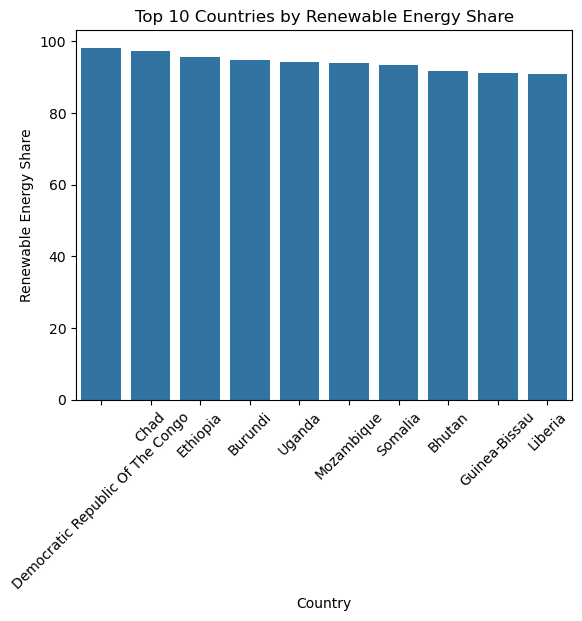

In [44]:
top_countries = merged.groupby('country_iso')['Renewable_Energy_Share'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Renewable Energy Share')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Country')
plt.show()

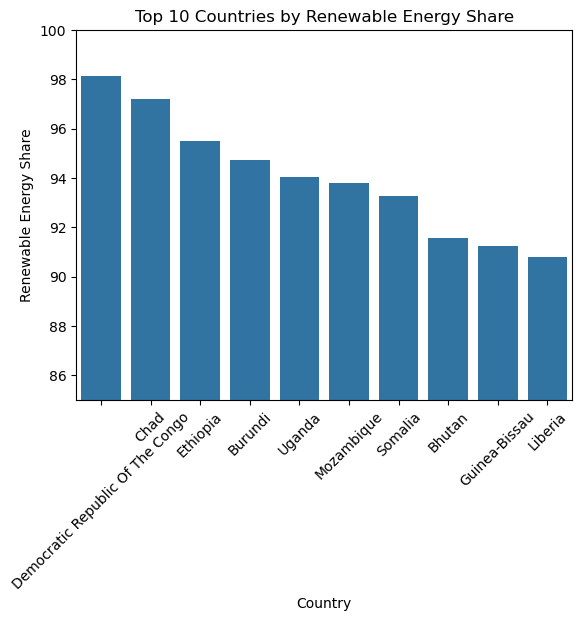

In [45]:
top_countries = merged.groupby('country_iso')['Renewable_Energy_Share'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by Renewable Energy Share')
plt.ylabel('Renewable Energy Share')
plt.ylim(85, 100)
plt.xlabel('Country')
plt.show()

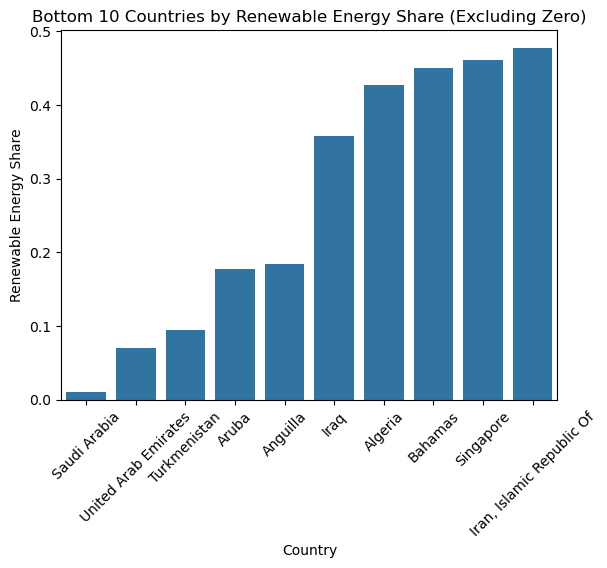

In [46]:
bottom_countries = (
    merged[merged['Renewable_Energy_Share'] > 0]
    .groupby('country_iso')['Renewable_Energy_Share']
    .mean()
    .sort_values(ascending=True)
    .head(10)
)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by Renewable Energy Share (Excluding Zero)')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Country')
plt.show()

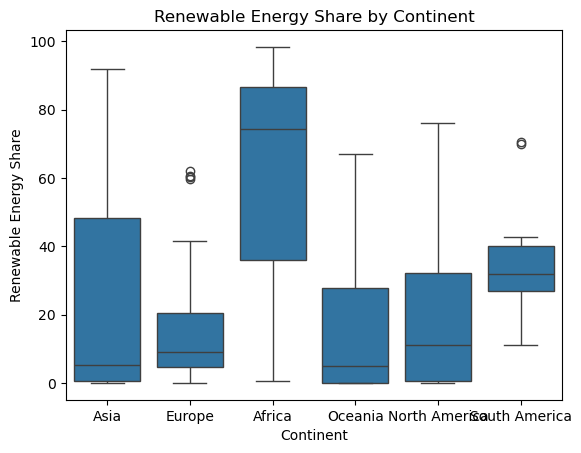

In [47]:
sns.boxplot(data=merged, x='continent', y='Renewable_Energy_Share')
plt.title('Renewable Energy Share by Continent')
plt.ylabel('Renewable Energy Share')
plt.xlabel('Continent')
plt.show()

### GII

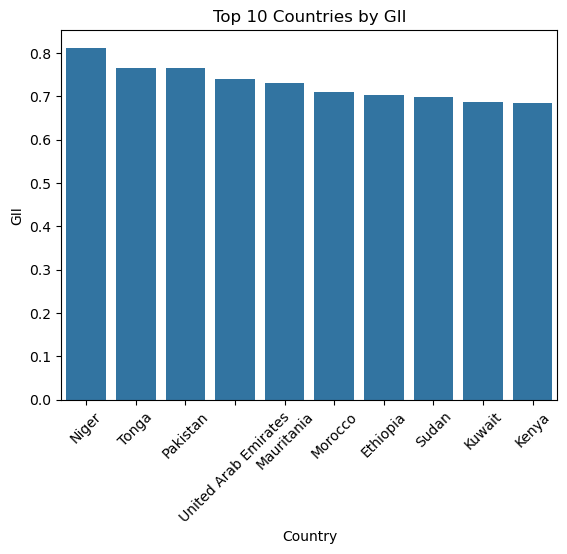

In [23]:
top_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.xticks(rotation=45)
plt.title('Top 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

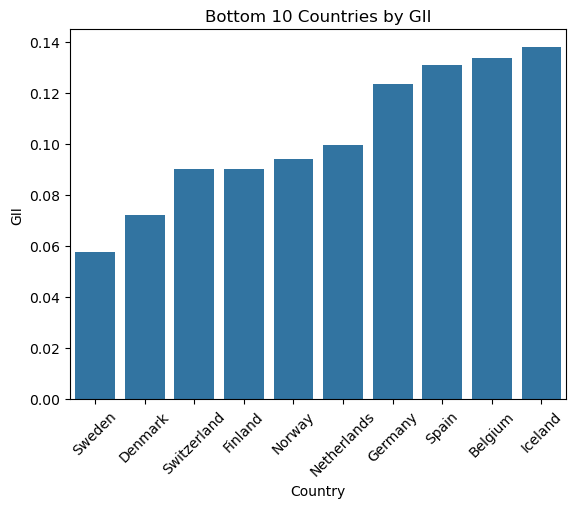

In [24]:
bottom_countries = merged.groupby('country')['GII'].mean().sort_values(ascending=True).head(10)
sns.barplot(x=bottom_countries.index, y=bottom_countries.values)
plt.xticks(rotation=45)
plt.title('Bottom 10 Countries by GII')
plt.ylabel('GII')
plt.xlabel('Country')
plt.show()

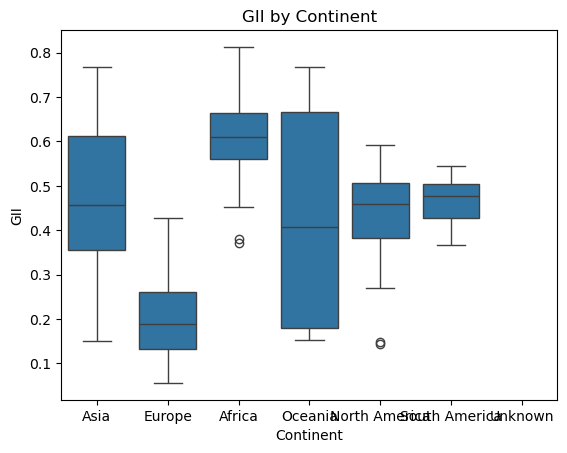

In [25]:
sns.boxplot(data=merged, x='continent', y='GII')
plt.title('GII by Continent')
plt.ylabel('GII')
plt.xlabel('Continent')
plt.show()

### Let's see their relation

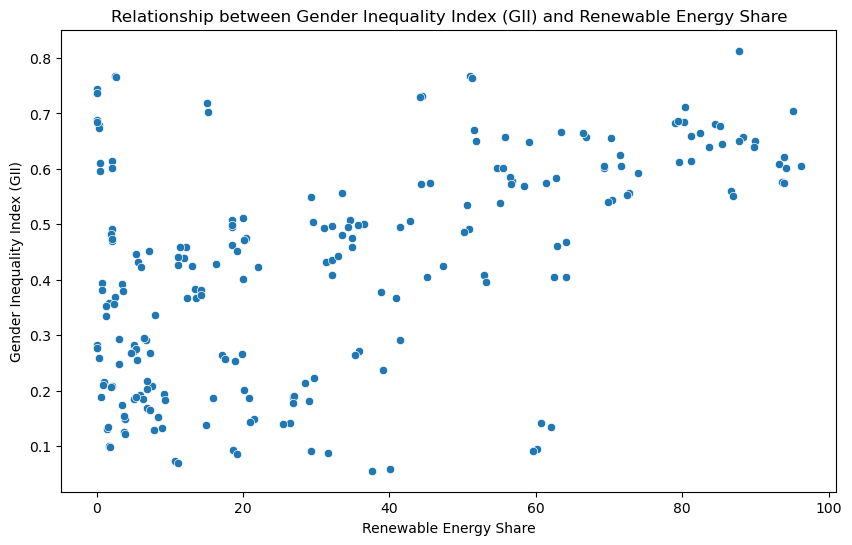

In [26]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=merged, x='Renewable_Energy_Share', y='GII', legend=True)
plt.title('Relationship between Gender Inequality Index (GII) and Renewable Energy Share')
plt.xlabel('Renewable Energy Share')
plt.ylabel('Gender Inequality Index (GII)')
plt.show()

### Correlation exploration

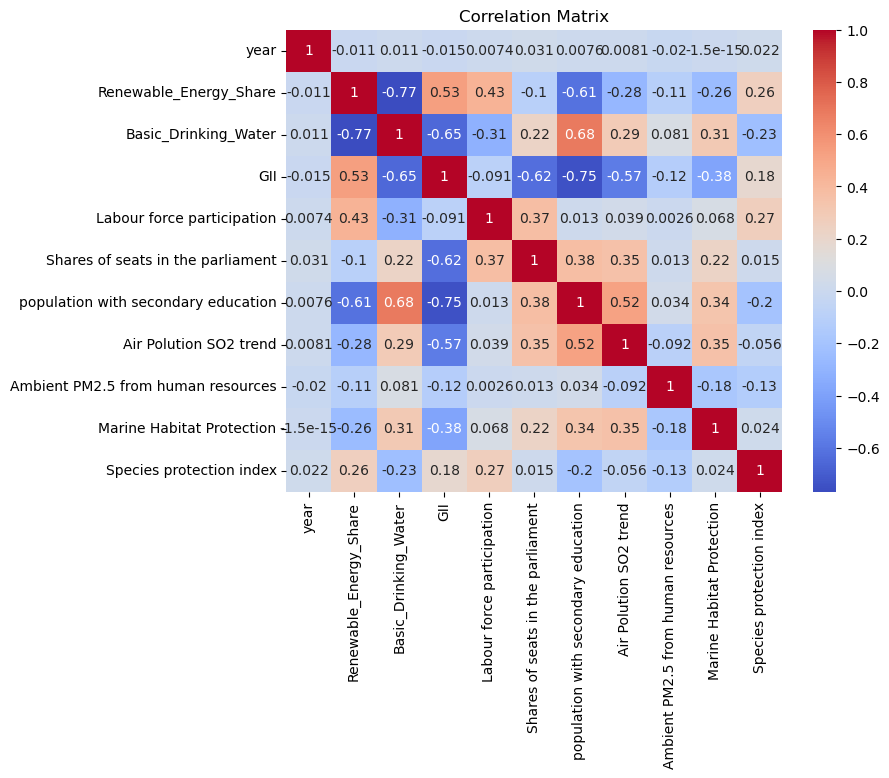

In [27]:
plt.figure(figsize=(8,6))
sns.heatmap(merged.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

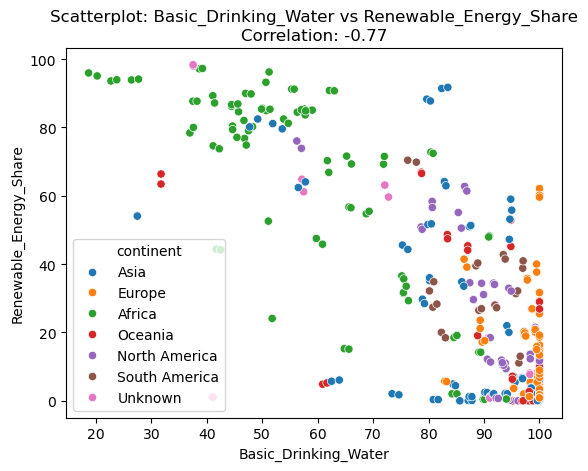

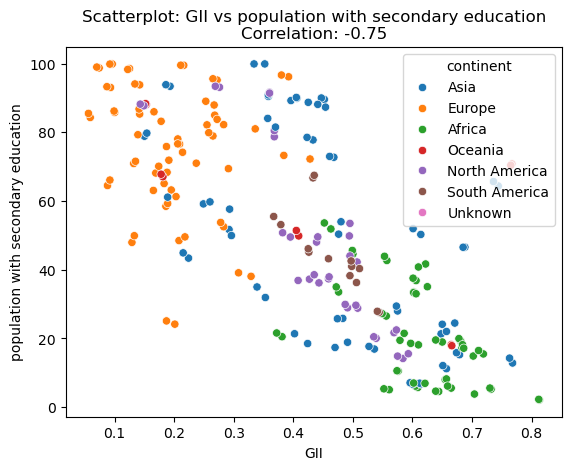

In [28]:
corr = merged.corr(numeric_only=True)

# Relationships with correlation > 0.7
high_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and abs(corr.loc[col1, col2]) > 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in high_corr:
                high_corr.append(pair)

for col1, col2 in high_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

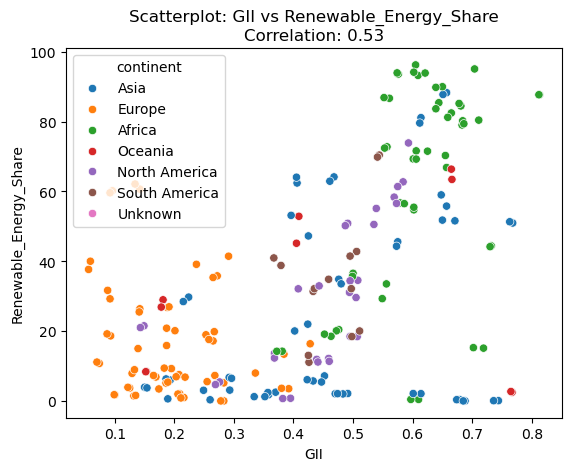

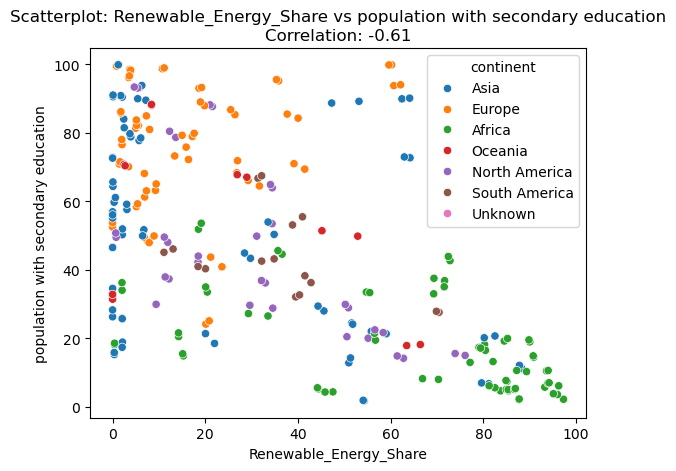

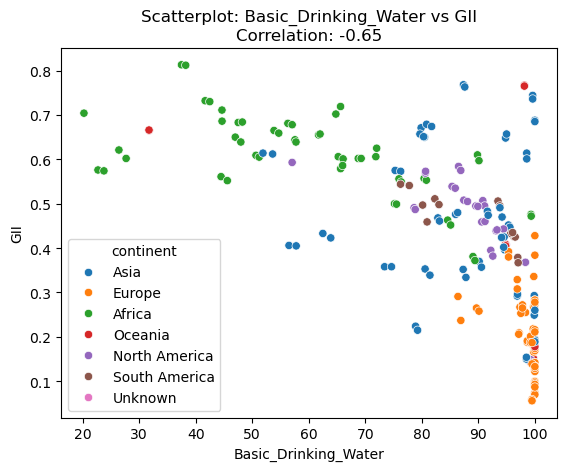

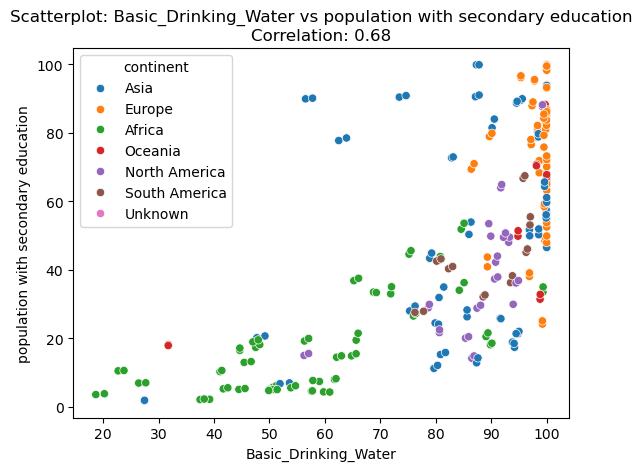

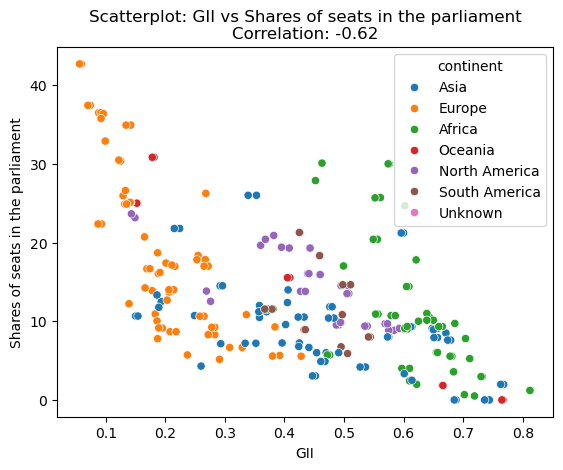

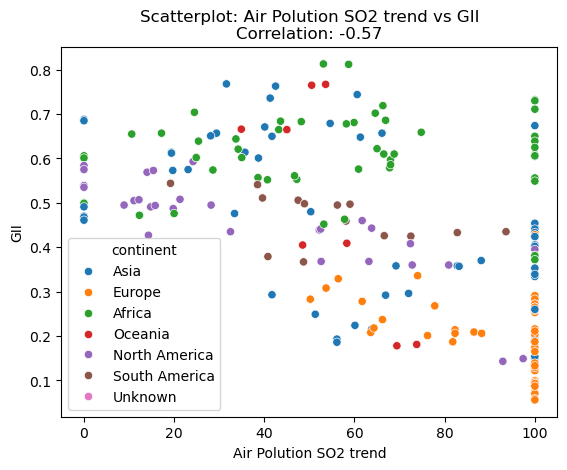

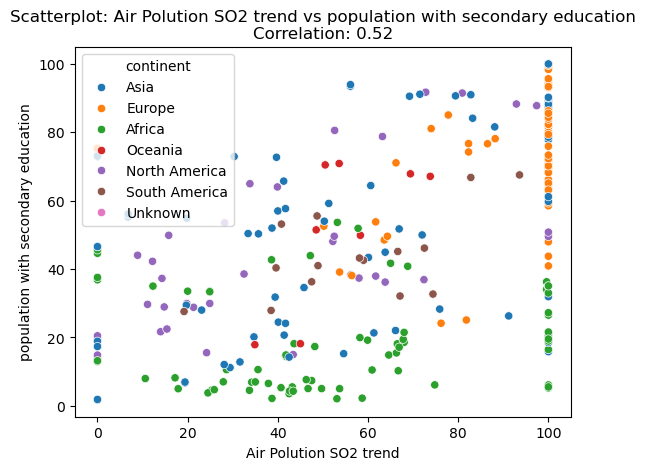

In [29]:
corr = merged.corr(numeric_only=True)

# Relationships with 0.5 < correlation <= 0.7
medium_corr = []
for col1 in corr.columns:
    for col2 in corr.columns:
        if col1 != col2 and 0.5 < abs(corr.loc[col1, col2]) <= 0.7:
            pair = tuple(sorted([col1, col2]))
            if pair not in medium_corr:
                medium_corr.append(pair)

for col1, col2 in medium_corr:
    sns.scatterplot(data=merged, x=col1, y=col2, hue='continent', legend=True)
    plt.title(f'Scatterplot: {col1} vs {col2}\nCorrelation: {corr.loc[col1, col2]:.2f}')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()

# Exploratory Analysis
## Basic info & missing values

In [30]:
merged.info()
merged.describe()
merged.isna().sum()

<class 'wbdata.client.DataFrame'>
Index: 472 entries, 0 to 715
Data columns (total 14 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   country                              472 non-null    object 
 1   year                                 472 non-null    int64  
 2   Renewable_Energy_Share               395 non-null    float64
 3   Basic_Drinking_Water                 372 non-null    float64
 4   GII                                  241 non-null    float64
 5   Labour force participation           290 non-null    float64
 6   Shares of seats in the parliament    336 non-null    float64
 7   population with secondary education  296 non-null    float64
 8   Air Polution SO2 trend               370 non-null    float64
 9   Ambient PM2.5 from human resources   380 non-null    float64
 10  Marine Habitat Protection            294 non-null    float64
 11  Species protection index             342 

country                                  0
year                                     0
Renewable_Energy_Share                  77
Basic_Drinking_Water                   100
GII                                    231
Labour force participation             182
Shares of seats in the parliament      136
population with secondary education    176
Air Polution SO2 trend                 102
Ambient PM2.5 from human resources      92
Marine Habitat Protection              178
Species protection index               130
country_iso                              0
continent                                0
dtype: int64

## Distribution and Outliers

array([[<Axes: title={'center': 'Renewable_Energy_Share'}>,
        <Axes: title={'center': 'Basic_Drinking_Water'}>,
        <Axes: title={'center': 'GII'}>],
       [<Axes: title={'center': 'Labour force participation'}>,
        <Axes: title={'center': 'Shares of seats in the parliament'}>,
        <Axes: title={'center': 'population with secondary education'}>],
       [<Axes: title={'center': 'Air Polution SO2 trend'}>,
        <Axes: title={'center': 'Ambient PM2.5 from human resources'}>,
        <Axes: title={'center': 'Marine Habitat Protection'}>],
       [<Axes: title={'center': 'Species protection index'}>, <Axes: >,
        <Axes: >]], dtype=object)

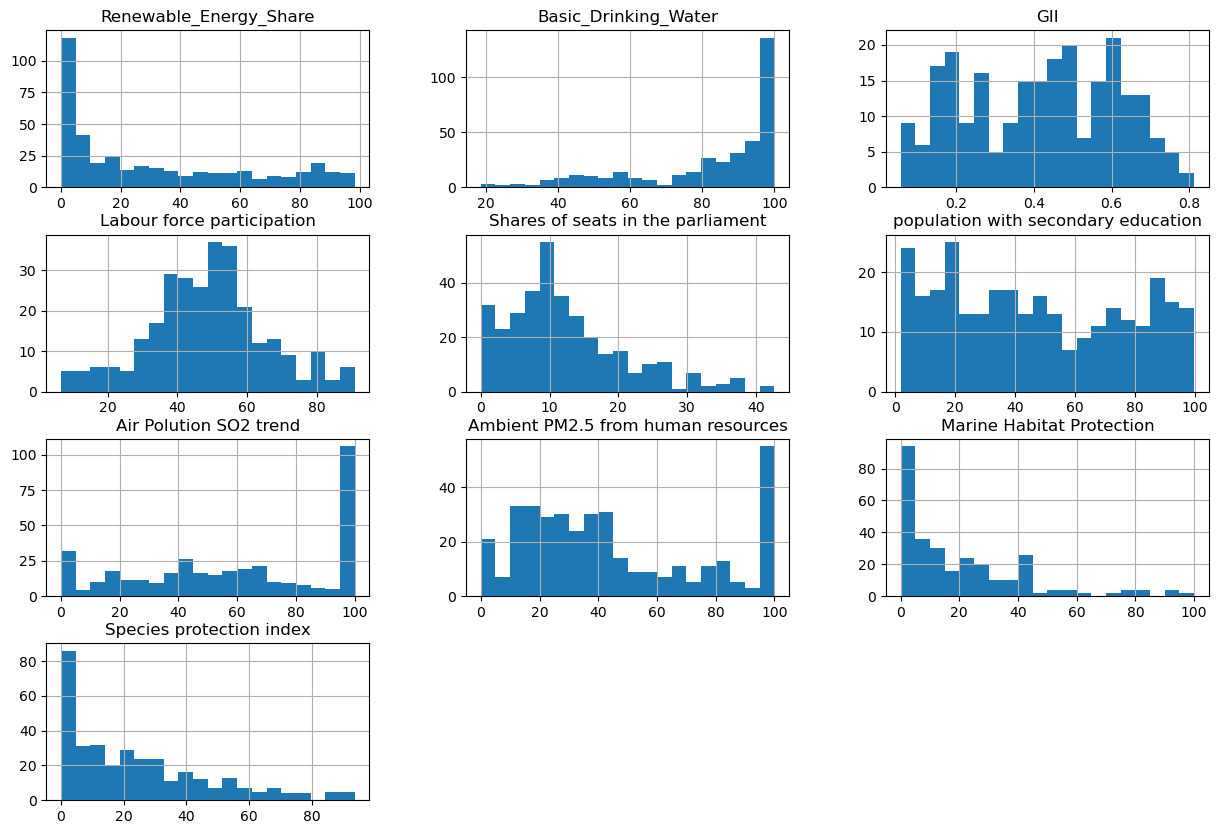

In [31]:
numeric_cols = ['Renewable_Energy_Share', 'Basic_Drinking_Water', 'GII',
                'Labour force participation', 'Shares of seats in the parliament',
                'population with secondary education', 'Air Polution SO2 trend',
                'Ambient PM2.5 from human resources', 'Marine Habitat Protection',
                'Species protection index']

merged[numeric_cols].hist(figsize=(15,10), bins=20)


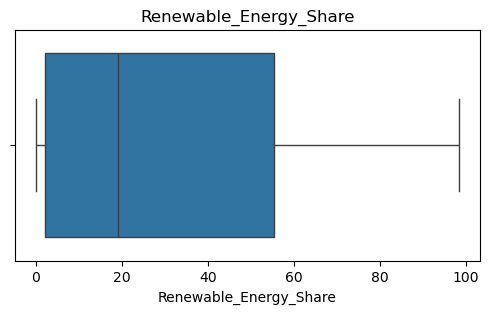

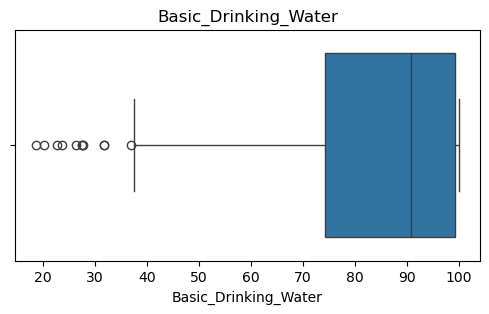

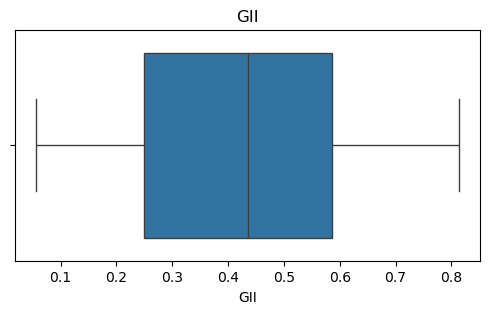

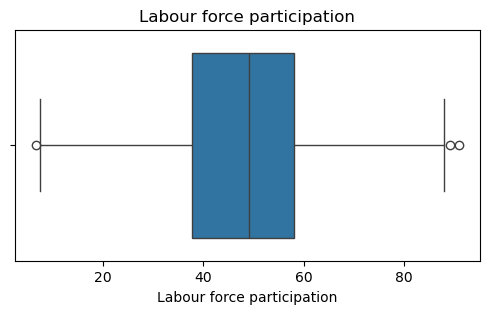

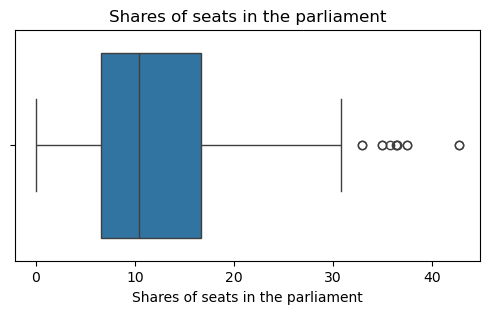

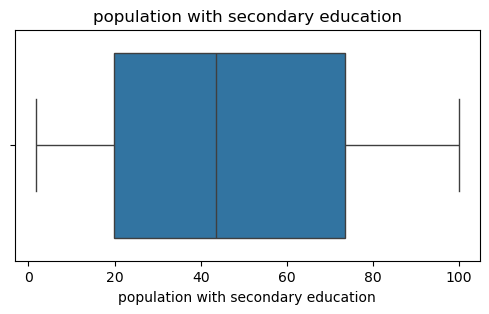

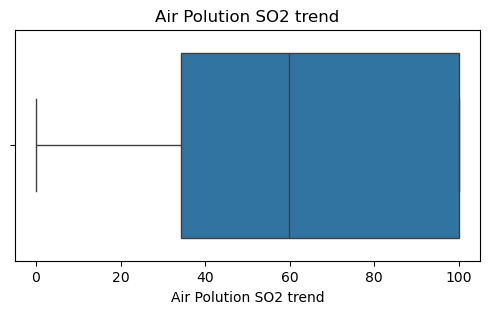

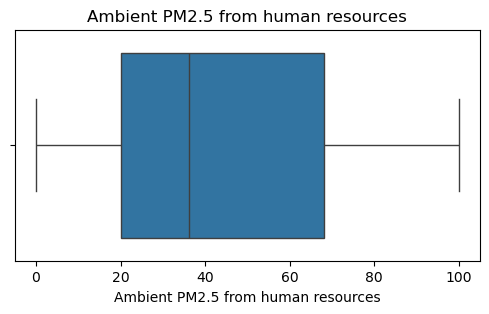

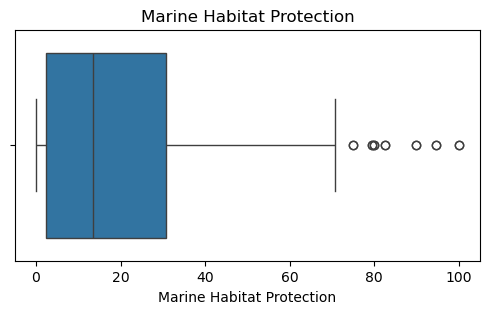

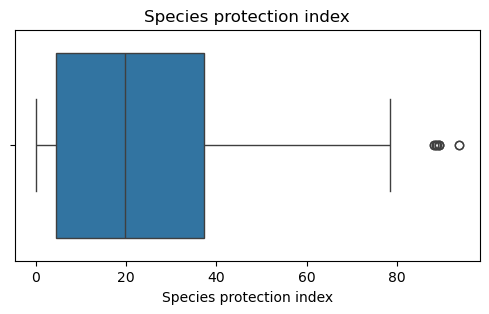

In [32]:
# boxplot to check for outliers
for col in numeric_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=merged[col])
    plt.title(col)
    plt.show()

## Temporal trends

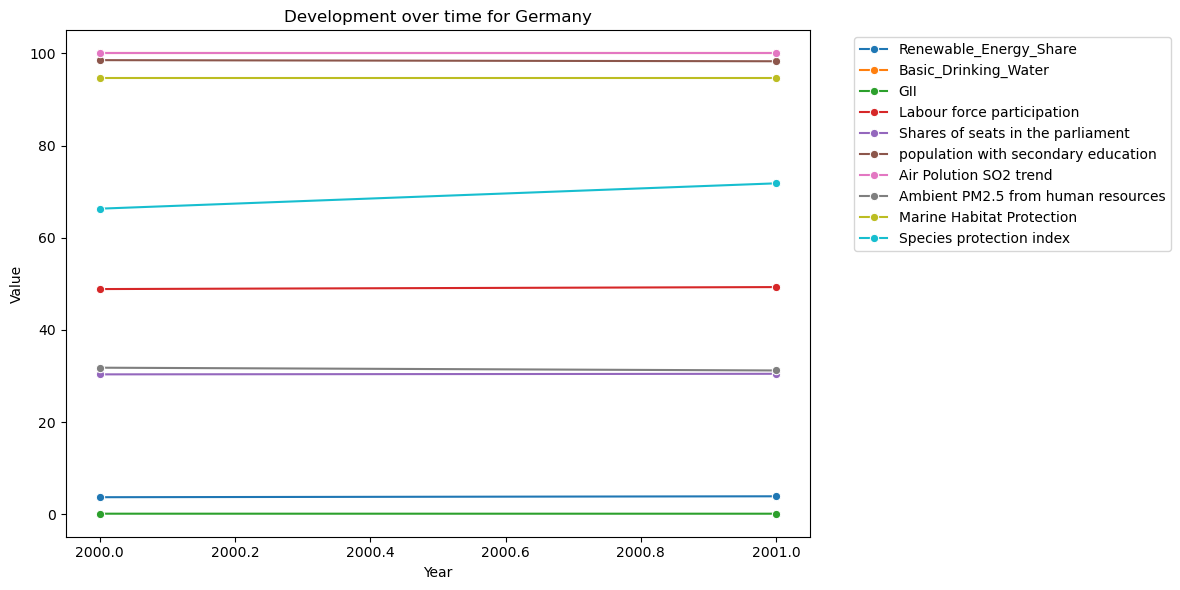

In [33]:
country_name = 'Germany'  

country_df = merged[merged['country'] == country_name]
numeric_cols = country_df.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('year')  
plot_df = country_df.melt(id_vars='year', value_vars=numeric_cols, 
                          var_name='Indicator', value_name='Value')

plt.figure(figsize=(12,6))
sns.lineplot(data=plot_df, x='year', y='Value', hue='Indicator', marker='o')
plt.title(f'Development over time for {country_name}')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout()
plt.show()

not interesting cause only two years 

In [34]:
print(merged.columns)


Index(['country', 'year', 'Renewable_Energy_Share', 'Basic_Drinking_Water',
       'GII', 'Labour force participation',
       'Shares of seats in the parliament',
       'population with secondary education', 'Air Polution SO2 trend',
       'Ambient PM2.5 from human resources', 'Marine Habitat Protection',
       'Species protection index', 'country_iso', 'continent'],
      dtype='object')


## GII Correlation

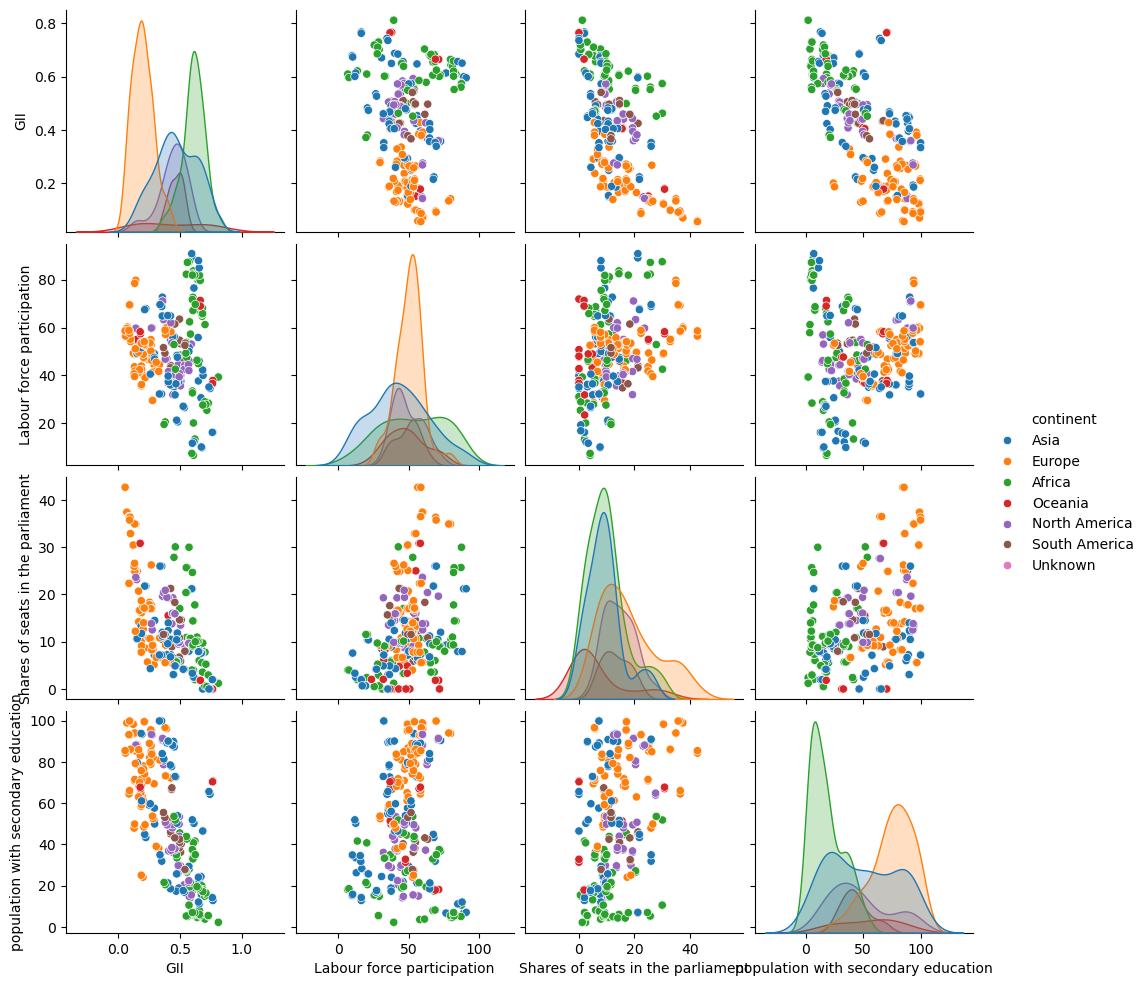

In [35]:
sns.pairplot(merged[['GII', 
                     'Labour force participation', 
                     'Shares of seats in the parliament', 
                     'population with secondary education', 
                     'continent']], 
             hue='continent')
plt.show()


In [36]:
!pip install ipywidgets

In [37]:
import ipywidgets as widgets
from IPython.display import display

variables = ['Labour force participation',
             'Shares of seats in the parliament',
             'population with secondary education']

agg_df = merged.groupby('country')[variables + ['GII']].mean().reset_index()

for var in variables:
    min_val = agg_df[var].min()
    max_val = agg_df[var].max()
    agg_df[var] = (agg_df[var] - min_val) / (max_val - min_val)


def update_plot(w1, w2, w3):
    total = w1 + w2 + w3
    if total == 0:
        return
    w1, w2, w3 = w1/total, w2/total, w3/total

    agg_df['weighted_indecators'] = (w1*agg_df[variables[0]] +
                                    w2*agg_df[variables[1]] +
                                    w3*agg_df[variables[2]])
    
    corr = agg_df['weighted_indecators'].corr(agg_df['GII'])
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=agg_df, x='weighted_indecators', y='GII', s=100)
    plt.title(f'Weighted Indicators vs GII\nCorrelation: {corr:.2f}')
    plt.xlabel('Weighted Indicator')
    plt.ylabel('GII')
    plt.show()

w1_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Labour')
w2_slider = widgets.FloatSlider(value=0.33, min=0, max=1, step=0.05, description='Parliament')
w3_slider = widgets.FloatSlider(value=0.34, min=0, max=1, step=0.05, description='Education')

sliders = widgets.VBox([w1_slider, w2_slider, w3_slider])
figure = widgets.interactive_output(update_plot, {'w1': w1_slider, 'w2': w2_slider, 'w3': w3_slider})

display(sliders, figure)


Output()

It probably makes sense to have a structure for the exploratory analysis and not just random action with data and visualizations. Maybe something like this:
1. basic stats & missing values (fill missing values or exclude?)
2. distributions and outliers (get a general idea for what values there are, are there crazy outliers)
3. somewhat summarize countries/continents and maybe decide on a limited number that we will continue exploring
4. correlation / trends in the data with plots to visualize 